In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression

In [4]:
sns.set_style('ticks')
sns.set_context('talk')

In [5]:
import warnings; warnings.simplefilter('ignore')

In [6]:
data_dir = '/home/julia/data/ict/'

## Absolute signal over sessions

In [7]:
mice = ['SHA', 'YOU','TAY', 'UUU', 'VVV', 'WEY']
colors = sns.color_palette('cubehelix_r', 6)
days = [-3,-2,-1,0,1,2]

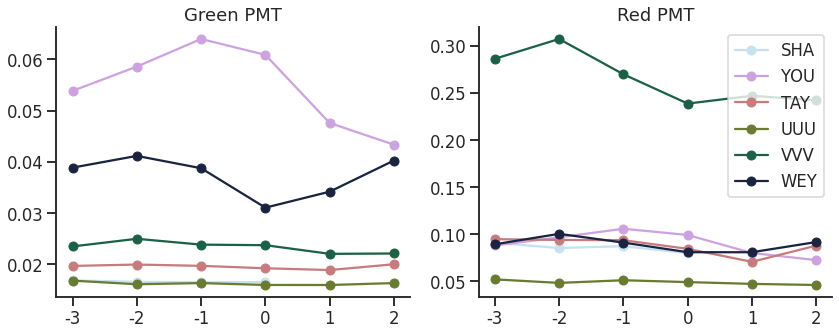

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
for mouse in range(len(days)):
    df = pd.read_pickle(data_dir+'mice/{}.pkl'.format(mice[mouse]))

    signal_means = []
    reference_means = []
    for day in range(len(days)):
        signal_series = df[(df['day']==days[day])]['gpmt']
        raw_signal = np.empty(0)
        for trial in signal_series:
            raw_signal = np.append(raw_signal, trial)

        reference_series = df[(df['day']==days[day])]['rpmt']
        raw_reference = np.empty(0)
        for trial in reference_series:
            raw_reference = np.append(raw_reference, trial)

        signal_means.append(np.mean(raw_signal))
        reference_means.append(np.mean(raw_reference))
            
    ax[0].plot(signal_means, marker='o', label=mice[mouse], color=colors[mouse])
    ax[1].plot(reference_means, marker='o', label=mice[mouse], color=colors[mouse])  

ax[0].set_title('Green PMT')
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([-3,-2,-1,0,1,2])
ax[1].set_title('Red PMT')
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([-3,-2,-1,0,1,2])
ax[1].legend()

plt.tight_layout()
sns.despine()

## Smooth and and calculate F/F0 for each trial

In [10]:
raw_signal = df[(df['day']==days[day])]['gpmt']
raw_reference = df[(df['day']==days[day])]['rpmt']
odor_start = df[(df['day']==days[day])]['odor_start']

remove = 1000
all_signal = np.empty(0)
all_reference = np.empty(0)

for trial in range(len(raw_signal)):
    smooth_signal = gaussian_filter1d(raw_signal.iloc[trial], sigma=100, axis=0, output=np.float64)
    smooth_reference = gaussian_filter1d(raw_reference.iloc[trial], sigma=100, axis=0, output=np.float64)
    
    F0_signal = np.mean(smooth_signal[(odor_start.iloc[trial]-1000):odor_start.iloc[trial]])
    F0_reference = np.mean(smooth_reference[(odor_start.iloc[trial]-1000):odor_start.iloc[trial]])
    delta_signal = (smooth_signal - F0_signal) / F0_signal
    delta_reference = (smooth_reference - F0_reference) / F0_reference
    
    all_signal = np.append(all_signal, delta_signal[remove:-remove])
    all_reference = np.append(all_reference, delta_reference[remove:-remove])

## Fit linear regression

In [11]:
lin = LinearRegression()
n = len(all_reference)
model = lin.fit(all_reference.reshape(n,1), all_signal.reshape(n,1))
reference_fitted = lin.predict(all_reference.reshape(n,1)).reshape(n,)
all_corr_signal = (all_signal - reference_fitted)

In [12]:
idx=np.arange(0,all_signal.shape[0],100)

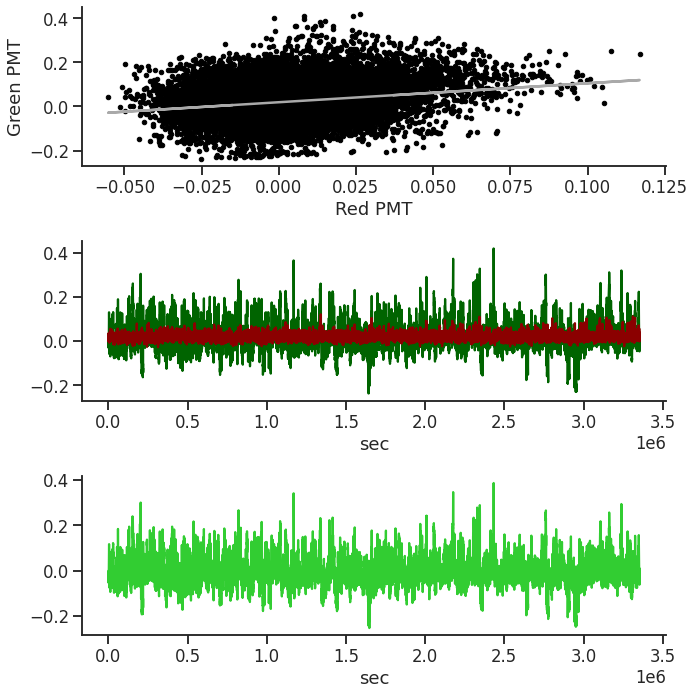

In [13]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
ax1.plot(all_reference[idx],all_signal[idx],'k.', linewidth=0)
ax1.plot(all_reference[idx],reference_fitted[idx], color='darkgrey', 
         linewidth=2.5)
ax1.set_xlabel('Red PMT')
ax1.set_ylabel('Green PMT')


ax2 = fig.add_subplot(312)
ax2.plot(all_signal,'darkgreen', label='Green PMT')
ax2.plot(reference_fitted,'darkred', label='Fitted Red PMT')
ax2.set_xlabel('sec')

ax3 = fig.add_subplot(313)
ax3.plot(all_corr_signal,'limegreen')
ax3.set_xlabel('sec')

plt.tight_layout()
sns.despine()

## Remove reference from signal for each trial

In [56]:
a = model.coef_[0,0]
b = model.intercept_[0]

In [66]:
raw_signal = df[(df['day']==days[day])]['gpmt']
raw_reference = df[(df['day']==days[day])]['rpmt']
odor_start = df[(df['day']==days[day])]['odor_start']

remove = 1000
corr_signal = []
for trial in range(len(raw_signal)):
    smooth_signal = gaussian_filter1d(raw_signal.iloc[trial], sigma=100, axis=0, output=np.float64)
    smooth_reference = gaussian_filter1d(raw_reference.iloc[trial], sigma=100, axis=0, output=np.float64)
    
    F0_signal = np.mean(smooth_signal[(odor_start.iloc[trial]-1000):odor_start.iloc[trial]])
    F0_reference = np.mean(smooth_reference[(odor_start.iloc[trial]-1000):odor_start.iloc[trial]])
    delta_signal = (smooth_signal - F0_signal) / F0_signal
    delta_reference = (smooth_reference - F0_reference) / F0_reference
    
    corr_signal.append(delta_signal - a*delta_reference - b)

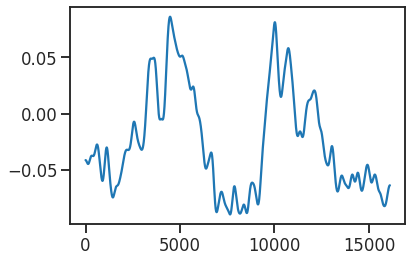

In [68]:
plt.plot(corr_signal[23])